In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from statsmodels.base.model import Results
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay,roc_curve, auc,recall_score
)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

## Base

In [8]:
df = pd.read_csv("clean.csv")
baseline_df = df.copy()
baseline_df = baseline_df.drop(columns=["Unnamed: 0", "ID"])

X = baseline_df.drop(columns=["Response"])
y = baseline_df["Response"]

# Label Encoding
label_encoders = {}
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

xgb_baseline = XGBClassifier(
    max_depth=4,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    # use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

xgb_baseline.fit(X_train, y_train)

y_pred = xgb_baseline.predict(X_test)
y_proba = xgb_baseline.predict_proba(X_test)[:, 1]

fpr_base,tpr_base,_ = roc_curve(y_test, y_proba)
auc_base = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

print("XGBoost-base AUC:", auc_base)
print("Report:",report)


XGBoost-base AUC: 0.6469915616974441
Report:               precision    recall  f1-score   support

           0       0.76      0.99      0.86      7735
           1       0.51      0.03      0.05      2442

    accuracy                           0.76     10177
   macro avg       0.64      0.51      0.46     10177
weighted avg       0.70      0.76      0.67     10177



#### Hyperparameter Tuning

In [9]:
# label encoding
label_encoders = {}
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

neg, pos = (y == 0).sum(), (y == 1).sum()
scale_pos_weight = neg / pos

param_dist = {
    "n_estimators": [200, 300],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "learning_rate": [0.05, 0.1, 0.2],
    "scale_pos_weight": [scale_pos_weight]
}

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    # use_label_encoder=False,
    random_state=42
)

stratified_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    scoring="roc_auc",
    n_iter=20,
    cv=stratified_cv,
    verbose=100,
    n_jobs=1,
    random_state=42,
    return_train_score=True
)
rs.fit(X_train, y_train)

best_model = rs.best_estimator_
print("Best parameter:", rs.best_params_)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

fpr_tuned, tpr_tuned, thresholds = roc_curve(y_test, y_proba)
auc_tuned = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

print(f"AUC: {auc_tuned:.4f}")
print("Classificaiton Report:\n", report)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200, scale_pos_weight=3.1675812924891473, subsample=1.0
[CV 1/5; 1/20] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200, scale_pos_weight=3.1675812924891473, subsample=1.0;, score=(train=0.734, test=0.657) total time=   0.0s
[CV 2/5; 1/20] START colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200, scale_pos_weight=3.1675812924891473, subsample=1.0
[CV 2/5; 1/20] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200, scale_pos_weight=3.1675812924891473, subsample=1.0;, score=(train=0.733, test=0.649) total time=   0.0s
[CV 3/5; 1/20] START colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200, scale_pos_we

#### SMOTE

In [10]:
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.pipeline import Pipeline as ImbPipeline

df = pd.read_csv("clean.csv")
baseline_df = df.copy()
baseline_df = baseline_df.drop(columns=["Unnamed: 0", "ID"])

X = baseline_df.drop(columns=["Response"])
y = baseline_df["Response"]

# Label Encoding
label_encoders = {}
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train
xgb_smote = XGBClassifier(
    max_depth=4,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    classweight="balanced"
)

xgb_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = xgb_smote.predict(X_test)
y_proba_smote = xgb_smote.predict_proba(X_test)[:, 1]

fpr_sm,tpr_sm,thresholds = roc_curve(y_test, y_proba_smote)
auc_sm = roc_auc_score(y_test, y_proba_smote)
report_smote = classification_report(y_test, y_pred_smote)

print("XGBoost + SMOTE AUC:", auc_sm)
print("XGBoost + SMOTE Report:")
print(report_smote)

# Method 2: Pipeline
print("="*30,"Use Pipeline","="*30)

# Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Use pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        max_depth=4,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        classweight="balanced"
    ))
])

pipeline.fit(X_train2, y_train2)

y_pred_pipe = pipeline.predict(X_test2)
y_proba_pipe = pipeline.predict_proba(X_test2)[:, 1]

fpr_pipe,tpr_pipe,_= roc_curve(y_test2, y_proba_pipe)
auc_pipe = roc_auc_score(y_test2, y_proba_pipe)
report_pipe = classification_report(y_test2, y_pred_pipe)

print("Pipeline (XGBoost + SMOTE) AUC:", auc_pipe)
print("Pipeline Report:")
print(report_pipe)

# SMOTE + Tuned
print("="*30,"Method 3","="*30)
print("Method 3: SMOTE + Hyperparameter Tuning")

from sklearn.model_selection import GridSearchCV
# SMOTE
X_train_smote3, y_train_smote3 = smote.fit_resample(X_train, y_train)
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_tuned = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    class_weight="balanced"
)

grid_search = GridSearchCV(
    estimator=xgb_tuned,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs= 1,
    verbose= 1
)

grid_search.fit(X_train_smote3, y_train_smote3)

print(f"Best params: {grid_search.best_params_}")
print(f"Best cross validation score: {grid_search.best_score_:.4f}")

best_xgb = grid_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test)
y_proba_tuned = best_xgb.predict_proba(X_test)[:, 1]

auc_tuned = roc_auc_score(y_test, y_proba_tuned)
report_tuned = classification_report(y_test, y_pred_tuned)

print("Tuned XGBoost + SMOTE AUC:", auc_tuned)
print("Tuned Report:")
print(report_tuned)

print("="*30,"Method 4: Compare different methods","="*30)
from imblearn.over_sampling import ADASYN, RandomOverSampler

sampling_methods = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42)
}

results = []

for name, sampler in sampling_methods.items():
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
    xgb_model = XGBClassifier(
        max_depth=4,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        classweight="balanced"
    )

    xgb_model.fit(X_train_resampled, y_train_resampled)

    y_pred = xgb_model.predict(X_test)
    y_proba = xgb_model.predict_proba(X_test)[:, 1]

    fpr,tpr,_ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    results.append({
        'method': name,
        'auc': auc_score,
        'fpr': fpr,
        'tpr': tpr,
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score']
    })

    print(f"{name} AUC: {auc_score:.4f}")

results_df = pd.DataFrame(results)
print("\nDifferent methods:")
print(results_df.round(4))

comparison = pd.DataFrame({
    'Method': ['SMOTE', 'Pipeline', 'Tuned_SMOTE'],
    'AUC': [auc_sm, auc_pipe, auc_tuned]
})
print(comparison.sort_values('AUC', ascending=False))



XGBoost + SMOTE AUC: 0.6000572559396089
XGBoost + SMOTE Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      7735
           1       0.32      0.27      0.29      2442

    accuracy                           0.69     10177
   macro avg       0.55      0.54      0.55     10177
weighted avg       0.67      0.69      0.68     10177

============================== Use Pipeline ==============================
Pipeline (XGBoost + SMOTE) AUC: 0.6000572559396089
Pipeline Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      7735
           1       0.32      0.27      0.29      2442

    accuracy                           0.69     10177
   macro avg       0.55      0.54      0.55     10177
weighted avg       0.67      0.69      0.68     10177

============================== Method 3 ==============================
Method 3: SMOTE + Hyperparameter Tuning
Fitting 3 folds for each of 

In [11]:
fpr_rd=results[2]['fpr']
tpr_rd=results[2]['tpr']
auc_rd=results[2]['auc']

In [14]:
results_df.head(3)

method       auc  \
0              SMOTE  0.600057   
1             ADASYN  0.597487   
2  RandomOverSampler  0.650592   

                                                 fpr  \
0  [0.0, 0.0, 0.00038784744667097606, 0.000387847...   
1  [0.0, 0.0001292824822236587, 0.000129282482223...   
2  [0.0, 0.0001292824822236587, 0.000387847446670...   

                                                 tpr  precision_1  recall_1  \
0  [0.0, 0.0004095004095004095, 0.000409500409500...     0.320718  0.270680   
1  [0.0, 0.0, 0.0004095004095004095, 0.0004095004...     0.311429  0.267813   
2  [0.0, 0.0, 0.0, 0.0012285012285012285, 0.00122...     0.323151  0.628174   

       f1_1  
0  0.293582  
1  0.287979  
2  0.426763

## Feature Engineering

In [8]:
data = pd.read_csv("clean.csv")
# target encoding
cat_mean = data.groupby('Reco_Policy_Cat')['Response'].mean()
data['Reco_Policy_Cat_enc'] = data['Reco_Policy_Cat'].map(cat_mean)

city_mean = data.groupby('City_Code')['Response'].mean()
data['City_Code_enc'] = data['City_Code'].map(city_mean)

region_mean = data.groupby('Region_Code')['Response'].mean()
data['Region_Code_encoded'] = data['Region_Code'].map(region_mean)

# delete columns
data = data.drop(columns=["Reco_Policy_Cat","City_Code","Region_Code"])

# One-Hot
data = pd.get_dummies(
    data,
    columns=['Reco_Insurance_Type', 'Accomodation_Type', 'Health_Indicator', 'Holding_Policy_Type','Is_Spouse'],
    drop_first=True
)

# number
num_features = ["Upper_Age","Lower_Age", "Reco_Policy_Premium", 'Holding_Policy_Duration']
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])

X = data.drop(columns=["Response"])
y = data["Response"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
xgb_baseline = XGBClassifier(
    max_depth=4,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    # use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

xgb_baseline.fit(X_train, y_train)

y_pred = xgb_baseline.predict(X_test)
y_proba = xgb_baseline.predict_proba(X_test)[:, 1]
fpr_fe, tpr_fe, thresholds = roc_curve(y_test, y_proba)
auc_fe = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

print("AUC:", auc_fe)
print("Report:",report)

D:\Users\linyanping\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:47:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.7427788957200722
Confusion Matrix: [[7390  345]
 [1962  480]]
Report:               precision    recall  f1-score   support

           0       0.79      0.96      0.86      7735
           1       0.58      0.20      0.29      2442

    accuracy                           0.77     10177
   macro avg       0.69      0.58      0.58     10177
weighted avg       0.74      0.77      0.73     10177



#### Hyperparameter Tuning

In [13]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (roc_auc_score, roc_curve, classification_report,
                             confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score)

param_space = {
    "n_estimators": [200, 300],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "learning_rate": [0.05, 0.1, 0.2],
    "scale_pos_weight": [scale_pos_weight]
}

xgb = XGBClassifier(
    # use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# set K-Fold validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_space,
    n_iter=30,
    scoring='roc_auc',
    cv=3,
    n_jobs=1,
    verbose=100,
    random_state=42,
    return_train_score=True
)

bayes_search.fit(X_train, y_train)
print("\nBest parameters:")
for param, value in bayes_search.best_params_.items():
    print(f"  {param}: {value}")

# Get Best Model
best_model = bayes_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
fpr_fe_tuned, tpr_fe_tuned, thresholds = roc_curve(y_test, y_proba)
auc_fe_tuned = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nAUC: {auc_fe_tuned:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}:")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

#### FE

In [7]:
def create_interaction_features_for_xgb(train_data, test_data):
    # Upper_Age * Reco_Policy_Premium
    train_data['Upper_Age_Premium_Interaction'] = train_data['Upper_Age'] * train_data['Reco_Policy_Premium']
    test_data['Upper_Age_Premium_Interaction'] = test_data['Upper_Age'] * test_data['Reco_Policy_Premium']

    # Upper_Age * Holding_Policy_Duration
    train_data['Upper_Age_Duration_Interaction'] = train_data['Upper_Age'] * train_data['Holding_Policy_Duration']
    test_data['Upper_Age_Duration_Interaction'] = test_data['Upper_Age'] * test_data['Holding_Policy_Duration']

    return train_data, test_data

In [9]:
def evaluate_xgboost_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification report:", classification_report(y_test, y_pred))

    return {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [12]:
from sklearn.model_selection import train_test_split

def encode_categorical_for_xgb(train_data, test_data):
    categorical_cols = [
        'Reco_Policy_Cat', 'City_Code', 'Region_Code',
        'Reco_Insurance_Type', 'Accomodation_Type',
        'Health_Indicator', 'Holding_Policy_Type', 'Is_Spouse'
    ]

    label_encoders = {}

    for col in categorical_cols:
        if col in train_data.columns:
            le = LabelEncoder()
            combined = pd.concat([train_data[col], test_data[col]], axis=0)
            le.fit(combined)

            train_data[f'{col}_encoded'] = le.transform(train_data[col])
            test_data[f'{col}_encoded'] = le.transform(test_data[col])
            label_encoders[col] = le

    return train_data, test_data, label_encoders

def prepare_features_for_xgb(X_train, y_train, X_test):
    train_data = X_train.copy()
    test_data = X_test.copy()
    train_data['Response'] = y_train.values

    train_data, test_data, label_encoders = encode_categorical_for_xgb(train_data, test_data)

    # Create interaction
    train_data, test_data = create_interaction_features_for_xgb(train_data, test_data)

    # delete
    categorical_cols = [
        'Reco_Policy_Cat', 'City_Code', 'Region_Code',
        'Reco_Insurance_Type', 'Accomodation_Type',
        'Health_Indicator', 'Holding_Policy_Type', 'Is_Spouse'
    ]

    columns_to_drop = [col for col in categorical_cols if col in train_data.columns]
    train_data = train_data.drop(columns=columns_to_drop)
    test_data = test_data.drop(columns=columns_to_drop)

    # Split
    X_train_final = train_data.drop(columns=['Response'])
    X_test_final = test_data
    return X_train_final, X_test_final, train_data['Response']

def train_xgboost_with_features(X_train, y_train, X_test, y_test):
    print("=" * 30, "XGBoost + Feature Engineering", "=" * 30)

    X_train_final, X_test_final, y_train_final = prepare_features_for_xgb(
        X_train, y_train, X_test
    )

    model = XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist'
    )

    model.fit(X_train_final, y_train_final)
    evaluation_results = evaluate_xgboost_model(model, X_test_final, y_test)

    return {
        'model': model,
        'X_train': X_train_final,
        'X_test': X_test_final,
        'y_train': y_train_final,
        'y_test': y_test,
        'evaluation': evaluation_results
    }

if __name__ == "__main__":
    data = pd.read_csv("clean.csv")
    X = data.drop(columns=["Response", "ID", "Unnamed: 0"])
    y = data["Response"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    result = train_xgboost_with_features(X_train, y_train, X_test, y_test)
    fpr_fe=result['evaluation']['fpr']
    tpr_fe=result['evaluation']['tpr']
    auc_fe=result['evaluation']['roc_auc']
    print(f"Test set ROC AUC: {result['evaluation']['roc_auc']:.4f}")

============================== XGBoost + Feature Engineering ==============================
ROC AUC: 0.6600
Classification report:               precision    recall  f1-score   support

           0       0.77      0.98      0.86      7735
           1       0.48      0.07      0.12      2442

    accuracy                           0.76     10177
   macro avg       0.63      0.52      0.49     10177
weighted avg       0.70      0.76      0.68     10177

Test set ROC AUC: 0.6600


#### FE + Tuning

In [3]:
def prepare_features_for_xgb(X_train, y_train, X_test):
    train_data = X_train.copy()
    test_data = X_test.copy()
    train_data['Response'] = y_train.values

    train_data, test_data, label_encoders = encode_categorical_for_xgb(train_data, test_data)

    # Create interaction
    train_data, test_data = create_interaction_features_for_xgb(train_data, test_data)

    # delete
    categorical_cols = [
        'Reco_Policy_Cat', 'City_Code', 'Region_Code',
        'Reco_Insurance_Type', 'Accomodation_Type',
        'Health_Indicator', 'Holding_Policy_Type', 'Is_Spouse'
    ]

    columns_to_drop = [col for col in categorical_cols if col in train_data.columns]
    train_data = train_data.drop(columns=columns_to_drop)
    test_data = test_data.drop(columns=columns_to_drop)

    # Split
    X_train_final = train_data.drop(columns=['Response'])
    X_test_final = test_data
    return X_train_final, X_test_final, train_data['Response']

In [5]:
def encode_categorical_for_xgb(train_data, test_data):
    categorical_cols = [
        'Reco_Policy_Cat', 'City_Code', 'Region_Code',
        'Reco_Insurance_Type', 'Accomodation_Type',
        'Health_Indicator', 'Holding_Policy_Type', 'Is_Spouse'
    ]

    label_encoders = {}

    for col in categorical_cols:
        if col in train_data.columns:
            le = LabelEncoder()
            combined = pd.concat([train_data[col], test_data[col]], axis=0)
            le.fit(combined)

            train_data[f'{col}_encoded'] = le.transform(train_data[col])
            test_data[f'{col}_encoded'] = le.transform(test_data[col])
            label_encoders[col] = le

    return train_data, test_data, label_encoders

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

def create_interaction_features_for_xgb(train_data, test_data):
    # Upper_Age * Reco_Policy_Premium
    train_data['Upper_Age_Premium_Interaction'] = train_data['Upper_Age'] * train_data['Reco_Policy_Premium']
    test_data['Upper_Age_Premium_Interaction'] = test_data['Upper_Age'] * test_data['Reco_Policy_Premium']

    # Upper_Age * Holding_Policy_Duration
    train_data['Upper_Age_Duration_Interaction'] = train_data['Upper_Age'] * train_data['Holding_Policy_Duration']
    test_data['Upper_Age_Duration_Interaction'] = test_data['Upper_Age'] * test_data['Holding_Policy_Duration']

    return train_data, test_data

def tune_xgboost(X_train, y_train, scoring='roc_auc'):
    param_grid = {
        "n_estimators": [200, 300],
        "max_depth": [3, 4, 5, 6],
        "min_child_weight": [1, 3, 5],
        "gamma": [0, 0.1, 0.2],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0],
        "learning_rate": [0.05, 0.1, 0.2],
    }

    grid_search = GridSearchCV(
        estimator=XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            tree_method='hist'
        ),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,
        n_jobs= 1,
        verbose=200
    )

    grid_search.fit(X_train, y_train)

    print(f"Best params: {grid_search.best_params_}")
    print(f" Best cross validation {scoring} score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

def evaluate_xgboost_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr,tpr,thresholds = roc_curve(y_test,y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification report:",classification_report(y_test, y_pred))

    return {
        'fpr':fpr,
        'tpr':tpr,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

def train_xgboost_with_features(X_train, y_train, X_test, y_test, scoring='roc_auc'):
    print("=" * 30, "XGBoost + Feature Engineering + Hyperparameter Tuning", "=" * 30)

    X_train_final, X_test_final, y_train_final = prepare_features_for_xgb(
        X_train, y_train, X_test
    )

    # Hyperparameter Tuning
    best_model, best_params, best_score = tune_xgboost(
        X_train_final, y_train_final, scoring
    )

    # Use best model to evaluate
    evaluation_results = evaluate_xgboost_model(best_model, X_test_final, y_test)

    # Cross validation
    cv_scores = cross_val_score(best_model, X_train_final, y_train_final,
                               cv=5, scoring='roc_auc')

    print(f"5 Fold ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    return {
        'model': best_model,
        'best_params': best_params,
        'best_cv_score': best_score,
        'X_train': X_train_final,
        'X_test': X_test_final,
        'y_train': y_train_final,
        'y_test': y_test,
        'evaluation': evaluation_results,
        'cv_scores': cv_scores
    }

def compare_with_baseline(X_train, y_train, X_test, y_test):
    result = train_xgboost_with_features(X_train, y_train, X_test, y_test)
    auc_engineered = result['evaluation']['roc_auc']

    result = pd.DataFrame({
        'Model': ['XGBoost + Feature Engineering'],
        'ROC AUC': [auc_engineered],
    })

    print(result)

    return result

if __name__ == "__main__":
    data = pd.read_csv("clean.csv")
    X = data.drop(columns=["Response", "ID", "Unnamed: 0"])
    y = data["Response"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    result = train_xgboost_with_features(X_train, y_train, X_test, y_test)
    fpr_fe_tuned=result['evaluation']['fpr']
    tpr_fe_tuned=result['evaluation']['tpr']
    auc_fe_tuned=result['evaluation']['roc_auc']

    print(f"Best params: {result['best_params']}")
    print(f"Best cross validation score: {result['best_cv_score']:.4f}")
    print(f"Test set ROC AUC: {result['evaluation']['roc_auc']:.4f}")

============================== XGBoost + Feature Engineering + Hyperparameter Tuning ==============================
Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
[CV 1/3; 1/1944] START colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7
[CV 1/3; 1/1944] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7;, score=0.628 total time=   0.0s
[CV 2/3; 1/1944] START colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7
[CV 2/3; 1/1944] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7;, score=0.618 total time=   0.1s
[CV 3/3; 1/1944] START colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7
[CV 3/3; 1/1944] END colsample_bytree=0.7, gamma=0, learning_r

#### Random+Tuning

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

def prepare_data():
    data = pd.read_csv("clean.csv")
    df = data.copy()
    df = df.drop(columns=["Unnamed: 0", "ID"])

    X = df.drop(columns=["Response"])
    y = df["Response"]

    # Label Encoding
    label_encoders = {}
    for col in X.select_dtypes(include="object").columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Train set - 0: {sum(y_train == 0)}, 1: {sum(y_train == 1)}")
    print(f"Test set - 0: {sum(y_test == 0)}, 1: {sum(y_test == 1)}")

    return X_train, X_test, y_train, y_test, label_encoders

def create_interaction_features(X_train, X_test):
    train_data = X_train.copy()
    test_data = X_test.copy()

    numerical_interactions = [
        ('Upper_Age', 'Reco_Policy_Premium'),
        ('Upper_Age', 'Holding_Policy_Duration'),
        ('Reco_Policy_Premium', 'Holding_Policy_Duration')
    ]

    for feat1, feat2 in numerical_interactions:
        if feat1 in train_data.columns and feat2 in train_data.columns:
            train_data[f'{feat1}_{feat2}_interaction'] = train_data[feat1] * train_data[feat2]
            test_data[f'{feat1}_{feat2}_interaction'] = test_data[feat1] * test_data[feat2]

    return train_data, test_data

def tune_xgboost_with_ros(X_train, y_train, scoring='roc_auc'):
    param_grid = {
        "xgb__n_estimators": [200, 300],
        "xgb__max_depth": [3, 4, 5, 6],
        "xgb__min_child_weight": [1, 3, 5],
        "xgb__gamma": [0, 0.1, 0.2],
        "xgb__subsample": [0.7, 0.8, 1.0],
        "xgb__colsample_bytree": [0.7, 0.8, 1.0],
        "xgb__learning_rate": [0.05, 0.1, 0.2]
    }

    pipeline = ImbPipeline([
        ('ros', RandomOverSampler(random_state=42)),
        ('xgb', XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            tree_method='hist'
        ))
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        cv=3,  # 使用3折交叉验证以加快速度
        n_jobs= 1,
        verbose=200
    )

    grid_search.fit(X_train, y_train)

    print(f"Best params: {grid_search.best_params_}")
    print(f"Best cross validation {scoring} score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:\n",classification_report(y_test, y_pred))

    return {
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'fpr':fpr,
        'tpr':tpr
    }

def train_final_model(X_train, y_train, X_test, y_test, best_params):
    ros = RandomOverSampler(random_state=42)
    X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

    print(f"After resample: 0: {sum(y_train_ros == 0)}, 1: {sum(y_train_ros == 1)}")
    xgb_params = {k.replace('xgb__', ''): v for k, v in best_params.items() if k.startswith('xgb__')}

    final_model = XGBClassifier(
        **xgb_params,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    final_model.fit(X_train_ros, y_train_ros)
    return final_model


def main():
    X_train, X_test, y_train, y_test, label_encoders = prepare_data()

    X_train_fe, X_test_fe = create_interaction_features(X_train, X_test)

    print("\nMethod 1: Use Pipeline to tune XGBoost")
    best_pipeline, best_params, best_score = tune_xgboost_with_ros(X_train_fe, y_train)

    print("\nPipeline model evaluation:")
    pipeline_results = evaluate_model(best_pipeline, X_test_fe, y_test)

    print("\nMethod 2: Use RandomOverSampler")
    final_model = train_final_model(X_train_fe, y_train, X_test_fe, y_test, best_params)

    final_results = evaluate_model(final_model, X_test_fe, y_test)
    cv_scores = cross_val_score(final_model, X_train_fe, y_train, cv=5, scoring='roc_auc')
    print(f"\n5 Fold cross validation ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


    print(f"Best cross validation score: {best_score:.4f}")
    print(f"Test set ROC AUC: {final_results['roc_auc']:.4f}")

    return {
        'best_pipeline': best_pipeline,
        'final_model': final_model,
        'best_params': best_params,
        'evaluation': final_results
    }

if __name__ == "__main__":
    result = main()
    fpr_rd_tuned=result['final_results']['fpr']
    tpr_rd_tuned=result['final_results']['tpr']
    auc_rd_tuned=result['final_results']['roc_auc']


Train set - 0: 30938, 1: 9767
Test set - 0: 7735, 1: 2442

Method 1: Use Pipeline to tune XGBoost
Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
[CV 1/3; 1/1944] START xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=200, xgb__subsample=0.7
[CV 1/3; 1/1944] END xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=200, xgb__subsample=0.7;, score=0.629 total time=   0.2s
[CV 2/3; 1/1944] START xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=200, xgb__subsample=0.7
[CV 2/3; 1/1944] END xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=200, xgb__subsample=0.7;, score=0.620 total time=   0.3s
[CV 3/3; 1/1944] START xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_r

KeyError: 'final_results'

In [6]:
fpr_rd_tuned=result['evaluation']['fpr']
tpr_rd_tuned=result['evaluation']['tpr']
auc_rd_tuned=result['evaluation']['roc_auc']

#### Tuning plot

In [10]:
def plot_tuning_trend(grid_search):
    results = grid_search.cv_results_
    plt.figure(figsize=(18, 6))
    plt.plot(range(len(results['params'])), results['mean_test_score'],
            'o-', linewidth=2, markersize=8, color='blue', label='Mean AUC')

    plt.fill_between(range(len(results['params'])),
                    results['mean_test_score'] - results['std_test_score'],
                    results['mean_test_score'] + results['std_test_score'],
                    alpha=0.2, color='blue', label='±1 std')

    best_idx = np.argmax(results['mean_test_score'])
    plt.plot(best_idx, results['mean_test_score'][best_idx], 'ro',
            markersize=12, label='Best Combination')

    plt.xlabel('Parameter Combination Index', fontsize=12)
    plt.ylabel('AUC Score', fontsize=12)
    plt.title('XGBoost Hyperparameter Tuning Performance Trend', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.annotate(f'Best: {results["mean_test_score"][best_idx]:.4f}',
                xy=(best_idx, results['mean_test_score'][best_idx]),
                xytext=(best_idx+2, results['mean_test_score'][best_idx]-0.02),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')

    plt.tight_layout()
    plt.show()

    return best_idx

============================== XGBoost + Feature Engineering + Hyperparameter Tuning ==============================
Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
[CV 1/3; 1/1944] START colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7
[CV 1/3; 1/1944] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7;, score=0.628 total time=   0.0s
[CV 2/3; 1/1944] START colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7
[CV 2/3; 1/1944] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7;, score=0.618 total time=   0.1s
[CV 3/3; 1/1944] START colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7
[CV 3/3; 1/1944] END colsample_bytree=0.7, gamma=0, learning_r

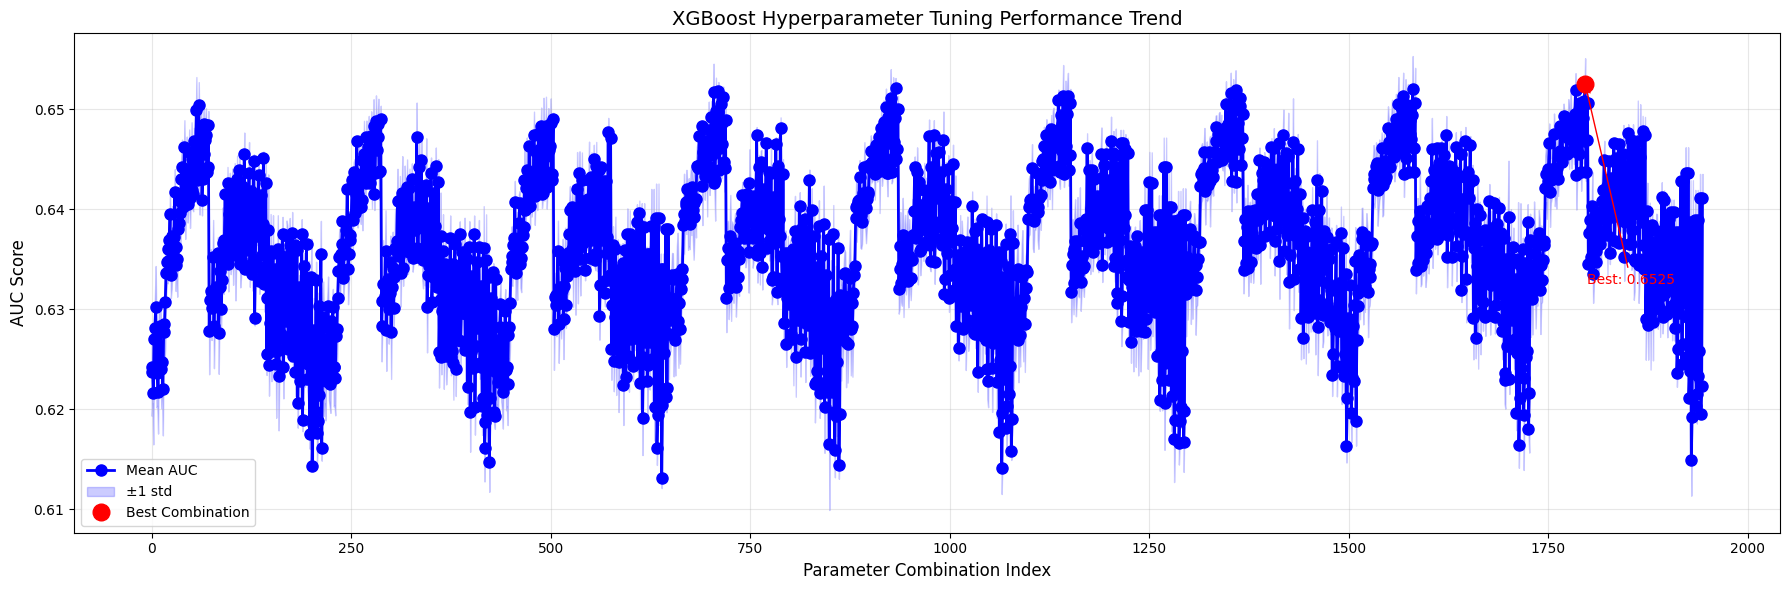


Best params (Index 1796):
  colsample_bytree: 1.0
  gamma: 0.2
  learning_rate: 0.05
  max_depth: 6
  min_child_weight: 5
  n_estimators: 200
  subsample: 1.0
  AUC Score: 0.6525
  Std: 0.0026
ROC AUC: 0.6668
Classification report:               precision    recall  f1-score   support

           0       0.76      1.00      0.86      7735
           1       0.63      0.02      0.03      2442

    accuracy                           0.76     10177
   macro avg       0.70      0.51      0.45     10177
weighted avg       0.73      0.76      0.66     10177

5 Fold ROC AUC: 0.6575 (±0.0035)
Best params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Best cross validation score: 0.6525
Test set ROC AUC: 0.6668


In [11]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

def tune_xgboost(X_train, y_train, scoring='roc_auc'):
    param_grid = {
        "n_estimators": [200, 300],
        "max_depth": [3, 4, 5, 6],
        "min_child_weight": [1, 3, 5],
        "gamma": [0, 0.1, 0.2],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0],
        "learning_rate": [0.05, 0.1, 0.2],
    }

    grid_search = GridSearchCV(
        estimator=XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            tree_method='hist'
        ),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,
        n_jobs=1,
        verbose=200
    )

    grid_search.fit(X_train, y_train)

    print(f"Best params: {grid_search.best_params_}")
    print(f" Best cross validation {scoring} score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_, grid_search

def plot_simplified_tuning_trend(grid_search, top_n=20):
    results = grid_search.cv_results_

    sorted_indices = np.argsort(results['mean_test_score'])[::-1][:top_n]
    sorted_scores = results['mean_test_score'][sorted_indices]
    sorted_stds = results['std_test_score'][sorted_indices]

    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(len(sorted_scores)), sorted_scores,
                  yerr=sorted_stds, alpha=0.7, capsize=5,
                  color=['lightblue'] * (len(sorted_scores) - 1) + ['red'])

    plt.xlabel('Top Parameter Combinations (Sorted by Performance)', fontsize=12)
    plt.ylabel('AUC Score', fontsize=12)
    plt.title(f'Top {top_n} XGBoost Parameter Combinations Performance\n(Best AUC: {sorted_scores[0]:.4f} ± {sorted_stds[0]:.4f})', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')

    plt.xticks(range(len(sorted_scores)), [f'#{i+1}' for i in range(len(sorted_scores))])

    for i, (score, std) in enumerate(zip(sorted_scores, sorted_stds)):
        plt.text(i, score + 0.001, f'{score:.4f}\n±{std:.4f}',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    return sorted_indices[0]

def plot_parameter_importance(grid_search, top_n=10):
    results = grid_search.cv_results_
    param_names = list(grid_search.param_grid.keys())

    param_importance = {}

    for param in param_names:
        param_values = grid_search.param_grid[param]
        mean_scores = []

        for value in param_values:
            indices = [i for i, params in enumerate(results['params'])
                      if params[param] == value]
            if indices:
                mean_score = np.mean([results['mean_test_score'][i] for i in indices])
                mean_scores.append((value, mean_score))

        mean_scores.sort(key=lambda x: x[1], reverse=True)
        param_importance[param] = mean_scores

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i, (param, scores) in enumerate(param_importance.items()):
        if i < len(axes):
            values, means = zip(*scores[:top_n])
            axes[i].bar(range(len(means)), means, alpha=0.7)
            axes[i].set_title(f'{param} Performance', fontsize=12)
            axes[i].set_xlabel('Parameter Value')
            axes[i].set_ylabel('Mean AUC')
            axes[i].set_xticks(range(len(values)))
            axes[i].set_xticklabels([str(v) for v in values], rotation=45)
            axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def train_xgboost_with_features(X_train, y_train, X_test, y_test, scoring='roc_auc'):
    print("=" * 30, "XGBoost + Feature Engineering + Hyperparameter Tuning", "=" * 30)

    X_train_final, X_test_final, y_train_final = prepare_features_for_xgb(
        X_train, y_train, X_test
    )

    best_model, best_params, best_score, grid_search = tune_xgboost(
        X_train_final, y_train_final, scoring
    )

    best_idx = plot_tuning_trend(grid_search)
    print(f"\nBest params (Index {best_idx}):")
    best_params_detail = grid_search.cv_results_['params'][best_idx]
    for param, value in best_params_detail.items():
        print(f"  {param}: {value}")
    print(f"  AUC Score: {grid_search.cv_results_['mean_test_score'][best_idx]:.4f}")
    print(f"  Std: {grid_search.cv_results_['std_test_score'][best_idx]:.4f}")

    # Use best model to evaluate
    evaluation_results = evaluate_xgboost_model(best_model, X_test_final, y_test)

    # Cross validation
    cv_scores = cross_val_score(best_model, X_train_final, y_train_final,
                               cv=5, scoring='roc_auc')

    print(f"5 Fold ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    return {
        'model': best_model,
        'best_params': best_params,
        'best_cv_score': best_score,
        'X_train': X_train_final,
        'X_test': X_test_final,
        'y_train': y_train_final,
        'y_test': y_test,
        'evaluation': evaluation_results,
        'cv_scores': cv_scores,
        'grid_search': grid_search  # 返回grid_search用于进一步分析
    }

if __name__ == "__main__":
    data = pd.read_csv("clean.csv")
    X = data.drop(columns=["Response", "ID", "Unnamed: 0"])
    y = data["Response"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    result = train_xgboost_with_features(X_train, y_train, X_test, y_test)
    fpr_fe_tuned = result['evaluation']['fpr']
    tpr_fe_tuned = result['evaluation']['tpr']
    auc_fe_tuned = result['evaluation']['roc_auc']

    print(f"Best params: {result['best_params']}")
    print(f"Best cross validation score: {result['best_cv_score']:.4f}")
    print(f"Test set ROC AUC: {result['evaluation']['roc_auc']:.4f}")

## ROC

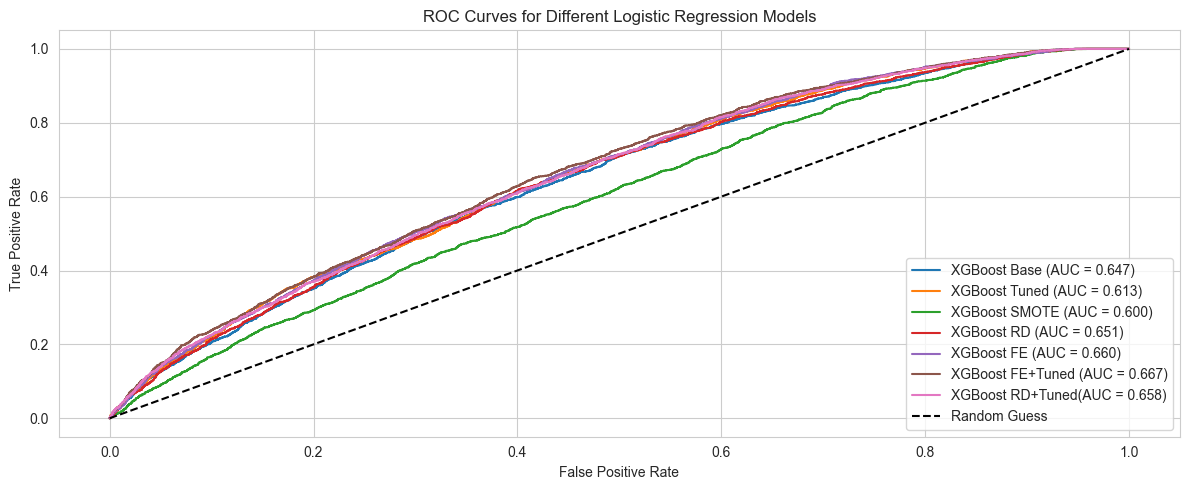

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.plot(fpr_base,  tpr_base,  label=f"XGBoost Base (AUC = {auc_base:.3f})")
plt.plot(fpr_tuned,  tpr_tuned,  label=f"XGBoost Tuned (AUC = {auc_tuned:.3f})")
plt.plot(fpr_sm,  tpr_sm,  label=f"XGBoost SMOTE (AUC = {auc_sm:.3f})")
plt.plot(fpr_rd,tpr_rd, label=f"XGBoost RD (AUC = {auc_rd:.3f})")
plt.plot(fpr_fe,  tpr_fe,  label=f"XGBoost FE (AUC = {auc_fe:.3f})")
plt.plot(fpr_fe_tuned,  tpr_fe_tuned,  label=f"XGBoost FE+Tuned (AUC = {auc_fe_tuned:.3f})")
plt.plot(fpr_rd_tuned,  tpr_rd_tuned,  label=f"XGBoost RD+Tuned(AUC = {auc_rd_tuned:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Logistic Regression Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()